In [9]:
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

In [10]:
# Custom dataset class
class BreastCancerDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.tensor(data).float()
        self.targets = torch.tensor(targets.values).long()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        return x, y
    
def initialize_population(population_size, num_features):
    return np.random.randint(2, size=(population_size, num_features))

def calculate_fitness(individual):
    selected_features = np.where(individual == 1)[0]
    if len(selected_features) == 0:
        return 0  # Penalize individuals with no selected features

    X_train_selected = X_train_scaled[:, selected_features]
    X_test_selected = X_test_scaled[:, selected_features]

    # Create custom dataset instances
    train_dataset = BreastCancerDataset(X_train_selected, y_train)
    test_dataset = BreastCancerDataset(X_test_selected, y_test)

    # Create k-Nearest Neighbors classifier with 7 neighbors
    classifier = KNeighborsClassifier(n_neighbors=7)

    # Train the classifier
    classifier.fit(train_dataset.data, train_dataset.targets)

    # Make predictions on the test set
    y_pred = classifier.predict(test_dataset.data)

    # Calculate accuracy
    accuracy = accuracy_score(test_dataset.targets, y_pred)

    num_selected_features = len(selected_features)
    num_features = X_train.shape[1]
    penalty = num_selected_features / num_features  # Penalty term

    return accuracy - 0.5*penalty  # Fitness value

def crossover(parent1, parent2, length):
    parent1 = np.array(parent1).flatten()
    parent2 = np.array(parent2).flatten()
    crossover_point = np.random.randint(1, length)
    child = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
    return child

def mutate(individual, mutation_rate):
    for i in range(len(individual)):
        if np.random.random() < mutation_rate:
            individual[i] = 1 - individual[i]  # Flip the bit
    return individual

def tournament_selection(population, fitness, tournament_size):
    selected = []
    remaining_indices = list(range(len(population)))

    while len(remaining_indices) >= tournament_size:
        indices = np.random.choice(remaining_indices, tournament_size, replace=False)
        tournament_fitness = [fitness[i] for i in indices]
        winner_idx = indices[np.argmax(tournament_fitness)]
        selected.append(population[winner_idx])
        remaining_indices.remove(indices[0])
        remaining_indices.remove(indices[1])
    return selected

def genetic_algorithm(X, y, population_size, num_generations, tournament_size):
    # Initialize population
    num_features = X.shape[1]  # Number of features
    population = initialize_population(population_size, num_features)

    best_fitness = []
    best_individual = None

    for generation in range(num_generations):
        print(f"Generation {generation+1} ->", end=" ")

        # Evaluate fitness
        fitness = []
        for individual in population:
            fitness_value = calculate_fitness(individual)
            fitness.append(fitness_value)

        # Track the fitness of the best individual for each generation
        best_index = np.argmax(fitness)
        best_fitness.append(fitness[best_index])
        best_individual = population[best_index]
        print(f"Best Individual Fitness: {fitness[best_index]}")
        # Print the best individual as a binary array
        selected_features = X.columns[np.where(best_individual == 1)[0]]
        print("Best Individual (Selected Features):", selected_features)

        # Select parents for reproduction
        selected_parents = np.array(tournament_selection(population, fitness, tournament_size))
        # Perform crossover and mutation to create offspring
        offspring = []
        while len(offspring) < len(population):
            selected_parents_idx = np.random.choice(len(selected_parents), size=2, replace=False)
            parent1, parent2 = selected_parents[selected_parents_idx]
            child1 = crossover(parent1, parent2, num_features)  # Each pair generates 2 children
            child2 = crossover(parent2, parent1, num_features)
            mutation_rate = 0.1
            child1 = mutate(child1, mutation_rate)
            child2 = mutate(child2, mutation_rate)
            offspring.append(child1)
            offspring.append(child2)
        offspring = np.array(offspring)
        # Replace current population with offspring and old population
        population = np.concatenate((population,offspring))
        # Evaluate fitness again
        fitness = []
        for individual in population:
            fitness_value = calculate_fitness(individual)
            fitness.append(fitness_value)      
        # Select survivors for the next generation
        population = tournament_selection(population, fitness, tournament_size)

    # Plot the fitness graph
    plt.plot(range(1,num_generations+1), best_fitness)
    plt.xlabel('Geração')
    plt.ylabel('Melhor Fitness')
    plt.title('Fitness do melhor indivíduo de cada geração - kNN')
    
    # Set the x-axis tick locations and labels
    plt.xticks(range(1,num_generations+1))
    
    # Save the graph as a PNG image
    plt.savefig('fitness_plot_kNN.png', format='png', bbox_inches='tight', dpi=300)
    
    plt.show()

    return best_individual

In [11]:
# Load the Breast Cancer Wisconsin dataset
data = pd.read_csv('data.csv')
data['class'] = [1 if x == 'M' else 0 for x in data['diagnosis']]
X = data.drop(columns=['diagnosis','id','Unnamed: 32','class'])
y = data['class']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

#Scaling the variables

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Generation 1 -> Best Individual Fitness: 0.8149122807017544
Best Individual (Selected Features): Index(['radius_mean', 'symmetry_mean', 'symmetry_se', 'radius_worst',
       'texture_worst', 'perimeter_worst', 'area_worst',
       'concave points_worst', 'fractal_dimension_worst'],
      dtype='object')
Generation 2 -> Best Individual Fitness: 0.8307017543859648
Best Individual (Selected Features): Index(['concavity_mean', 'radius_se', 'smoothness_se', 'concavity_se',
       'symmetry_se', 'texture_worst', 'fractal_dimension_worst'],
      dtype='object')
Generation 3 -> Best Individual Fitness: 0.8307017543859648
Best Individual (Selected Features): Index(['concavity_mean', 'radius_se', 'smoothness_se', 'concavity_se',
       'symmetry_se', 'texture_worst', 'fractal_dimension_worst'],
      dtype='object')
Generation 4 -> Best Individual Fitness: 0.8473684210526315
Best Individual (Selected Features): Index(['area_mean', 'concavity_mean', 'radius_se', 'compactness_se',
       'smoothn

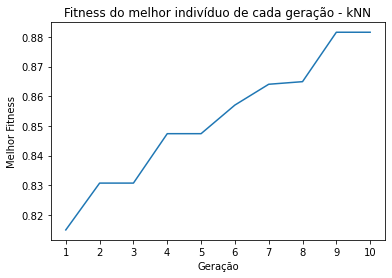

Selected Features: Index(['radius_mean', 'concavity_mean', 'fractal_dimension_mean', 'radius_se',
       'fractal_dimension_worst'],
      dtype='object')


In [12]:
# Run the genetic algorithm with kNN evaluation
best_individual = genetic_algorithm(X, y, population_size=50, num_generations=10, tournament_size=2)
selected_features = X.columns[np.where(best_individual == 1)[0]]
print("Selected Features:", selected_features)